# Deep Learning with PyTorch : Build a Generative Adversarial Network

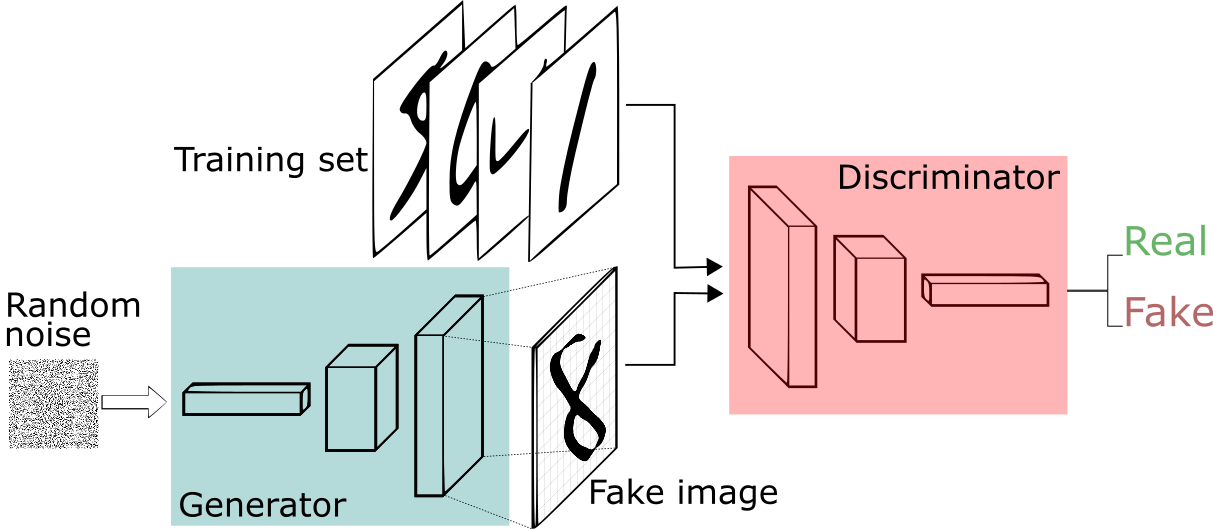

In [51]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [50]:
device = 'cpu' # image = image.to(device)

batch_size= 128 # used in train loader and training loop
noise_dim= 64 # shape of the random noise vector to be input to generator

# optimizer parameters

lr= 0.0002
beta1= 0.5 # used for adam opt
beta2= 0.99

# training params

epochs = 20

# Load MNIST Dataset

In [21]:
pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [55]:
import torchvision
from torchvision import datasets, transforms as T
print(torchvision.__version__)


0.18.0+cu121


In [56]:

train_augs = T.Compose([
    T.RandomRotation((-20,20)),
    T.ToTensor() # to convert the images to tensors (h,w,c) --> (c,h,w) because pytorch convention is different from PIL or numpy
])

In [57]:
trainset= datasets.MNIST('MNIST/',download = True, train = True, transform = train_augs)

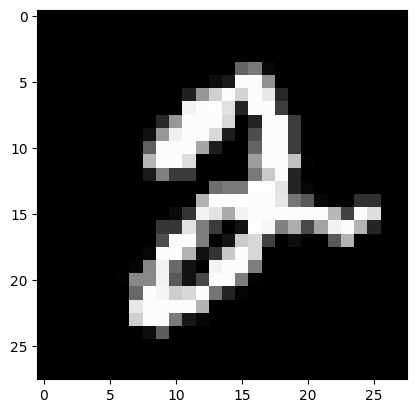

In [58]:
image ,label = trainset[5]
plt.imshow(image.squeeze(), cmap = 'gray')
plt.show()

In [59]:
print ("total images in the train set are :",len(trainset))

total images in the train set are : 60000


# Load Dataset Into Batches

In [60]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [61]:
trainloader=DataLoader(trainset, batch_size = batch_size, shuffle = True)


In [62]:
print ('total number of batches in train loader :', len(trainloader))


total number of batches in train loader : 469


In [63]:
dataiter= iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [64]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

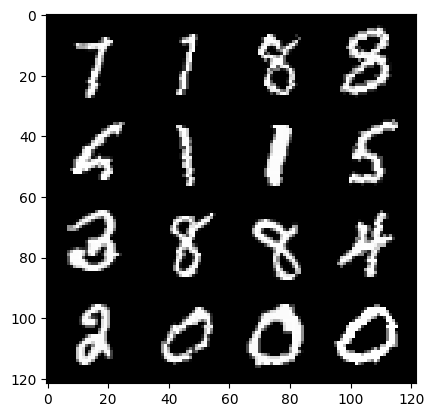

In [65]:
show_tensor_images(images,num_images=16)

# Create Discriminator Network

In [66]:
#In case if torch summary is not installed

!pip install torchsummary

In [67]:
from torch import nn
from torchsummary import summary

In [46]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [68]:
def get_disc_block(in_channels, out_channels,kernal_size, stride ):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = kernal_size, stride = stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [69]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.disc_block1 = get_disc_block(1,16,(3,3),2)
    self.disc_block2 = get_disc_block(16,32,(5,5),2)
    self.disc_block3 = get_disc_block(32,64,(5,5),2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64,out_features=1)
  def forward(self, images):
    x1 = self.disc_block1(images)
    x2 = self.disc_block2(x1)
    x3 = self.disc_block3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5

In [70]:
D = Discriminator().to(device)
summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [71]:
'''

Network : Generator

z_dim = 64 #noise
input : (bs,z_dim)

      |
      | Reshape : (bs, z_dim, 1, 1)
      |
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64 #noise\ninput : (bs,z_dim)\n\n      |\n      | Reshape : (bs, z_dim, 1, 1)\n      |\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                           

In [72]:
def get_gen_block(in_channels, out_channels,kernal_size, stride,final_block=False ):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernal_size, stride = stride),
        nn.Tanh()
    )
  else:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernal_size, stride = stride) ,
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [73]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block2 = get_gen_block(256,128,(4,4),1)
    self.block3 = get_gen_block(128,64,(3,3),2)
    self.block4 = get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self, r_noise_vec):
    #change shape of r_noise_vector from (bs,noise_dim) --> (bs,noise_dim,1,1)
    x=r_noise_vec.view(-1,self.noise_dim,1,1)
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)
    return x4

In [74]:
G = Generator(noise_dim) # create a generator instanse
G.to(device)  # move to GPU
summary(G, input_size= (noise_dim,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [75]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [76]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [77]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth= torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth= torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss



In [78]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 D_loss : 0.6828212514360831 G_loss : 0.6930640924459835


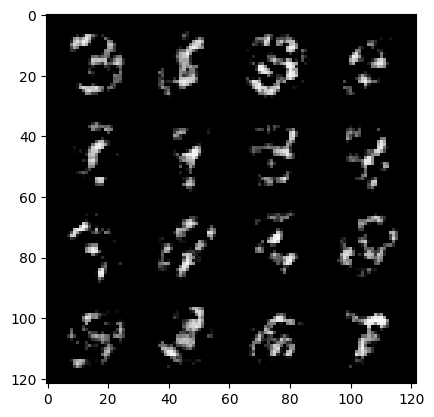

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 D_loss : 0.6777657180198474 G_loss : 0.7115909677070341


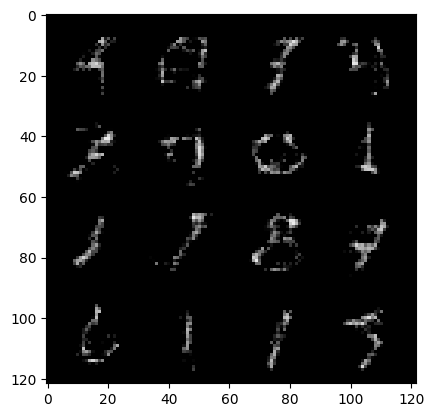

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
for i in range(epochs):
  total_d_loss=0
  total_g_loss=0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    # find loss and update weights for D

    D_optimizer.zero_grad()
    fake_img = G(noise)

    D_pred= D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred=D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_optimizer.step()


    # find loss and update weights for G

    G_optimizer.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)

    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()

    G_optimizer.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print(f"Epoch : {i+1} D_loss : {avg_d_loss} G_loss : {avg_g_loss}")

  show_tensor_images(fake_img)






In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya